In [41]:
import db_utils
import matplotlib.pyplot as plt, numpy as np, pandas as pd, plotly.express as px, plotly.io as pio, scipy, seaborn as sns, yaml
pio.renderers.default = "notebook"

'''
Loading the data and saving it into a csv file, then adjusting the data types of each column 
of the dataframe where needed as well as fixing any formatting inconsistencies
'''

with open('credentials.yaml') as file:
    credentials_dict = yaml.safe_load(file)
    
credentials = db_utils.RDSDatabaseConnector(credentials_dict)
loan_payments = credentials.initialise_database()
credentials.save_file(loan_payments, 'new_file.csv')

database = credentials.load_csv('new_file.csv')
data_transform = db_utils.DataTransform(database)

fixed_data = ['id','member_id']

date_data = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']

categorical_data = ['term', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 
                    'loan_status', 'payment_plan', 'purpose', 'policy_code', 'application_type']

non_numeric_data = date_data + categorical_data + fixed_data
numeric_data = [data_column for data_column in database.columns if data_column not in non_numeric_data]

for date_column in date_data:
    data_transform.date_data(date_column)

for categories in categorical_data:
    data_transform.change_type(categories, 'category')

'''
Dropping columns whose data consists of more than 50% of null values
and filling in the missing values for the other columns
'''

df_info = db_utils.DataFrameInfo(database)
df_transform = db_utils.DataFrameTransform(database)

for column in database.columns:
    null_vals, null_percentage = df_info.missing(column)
    if null_percentage > float(50):
        database.drop(column, axis=1, inplace=True)

database['funded_amount'] = database['loan_amount']

fill_values = {'collections_12_mths_ex_med': 0, 'term': database['term'].mode()[0], 'int_rate': database['int_rate'].mean}
df_transform.fill_null(values= fill_values)

for index in range(df_info.df_shape()[0]):
    if database.loc[index, 'collections_12_mths_ex_med'] == 0 and database.loc[index, 'last_payment_date'] != 'NaT':
        database.loc[index, 'collections_12_mths_ex_med'] += 1

    if database.loc[index, 'last_payment_date'] == 0:
        database.loc[index, 'last_payment_date'] = database.loc[index, 'last_credit_pull_date']

    if database.loc[index, 'last_credit_pull_date'] == 0:
        database.loc[index, 'last_credit_pull_date'] = database.loc[index, 'last_payment_date']

database.dropna(subset=['employment_length'], inplace=True)

In [42]:
'''
Finding the skew of the numerical columns in the dataframe and using log, boxcox 
and yeo johnson transformations to decrease the skewness of the data
'''

new_database = database.copy()
df2_transform = db_utils.DataFrameTransform(new_database)

original_skews = df_info.df_skew(database)
#df_info.df_skew(database, print=1)

skewed_data = database[[cols for cols, skews in original_skews.items() if skews > 2]]
log_skewed_data = yeojohnson_skew = boxcox_skew = skewed_data.copy()

log_skewed_data = df2_transform.log_transform(log_skewed_data)
yeojohnson_skew = df2_transform.yeojohnson_transform(yeojohnson_skew)
boxcox_skew = df2_transform.boxcox_transform(boxcox_skew)

log_skew = df_info.df_skew(log_skewed_data)
yeo_skew = df_info.df_skew(yeojohnson_skew)
box_skew = df_info.df_skew(boxcox_skew)

for column, col_vals in skewed_data.items():

    col_skew = abs(original_skews.get(column))

    log_col_skew = abs(log_skew[column])
    yeo_col_skew = abs(yeo_skew[column])
    
    smallest_skew = min(log_col_skew, yeo_col_skew, col_skew)
    
    if column in boxcox_skew.columns:
        box_col_skew = abs(box_skew[column])
    
        if box_col_skew <= smallest_skew:
            new_database[column] = boxcox_skew.loc[:, column]

    if smallest_skew == log_col_skew or smallest_skew == log_col_skew == yeo_col_skew:
        new_database[column] = log_skewed_data.loc[:, column]
    elif smallest_skew == yeo_col_skew:
        new_database[column] = yeojohnson_skew.loc[:, column]

#df_info.df_skew(new_database, print=1)

In [43]:
'''
Finding and removing outliers in the data.
'''
df_plot = db_utils.Plotter(new_database)

#df_plot.plot_boxplot(categories)
#df_plot.plot_scatter()

df2_transform.remove_outliers()
#df_plot.plot_boxplot(categories)
#df_plot.plot_scatter()

In [44]:
'''
Finding the correlation between the columns of the dataframe and 
removing columns which are extremely highly correlated.
'''

data_corr_matrix = new_database.corr(numeric_only = True).abs()
upper = data_corr_matrix.where(np.triu(np.ones(data_corr_matrix.shape), k=1).astype(bool))
to_drop = [database_col for database_col in upper.columns if any(upper[database_col] > 0.95)]
new_database.drop(to_drop, axis=1, inplace=True)

#px.imshow(new_database.corr(numeric_only = True), title = 'Heatmap using Pearson correlation coefficient')

In [45]:
''' 
Finding the amount of loans recovered and visualising the results.
'''

recovered_payments = unrecovered_payments = 0

for element in new_database['out_prncp']:
    if element > 0:
        unrecovered_payments += 1
    else:
        recovered_payments += 1

#df_plot.plot_pie([unrecovered_payments, recovered_payments], ['Unrecovered payments', 'Recovered payments'], 'The amount of loans recovered against the investor funding and the total amount funded')

'''
Visualising and finding the percentage of the total amount that would be recovered up to 6 months' in the future.
'''

for position, member in new_database.iterrows():
    if member['loan_status'] in ['Current', 'In Grace Period']:
        outstanding_principle = member['out_prncp']
        instalment = member['instalment']

        recovered_6months = 6 * instalment

        if recovered_6months > outstanding_principle:
            unrecovered_payments -= 1
            recovered_payments += 1

#df_plot.plot_pie([unrecovered_payments, recovered_payments], ['Unrecovered payments up to 6 months in the future', 'Recovered payments up to 6 months in the future'], 'The amount of loans recovered against the investor funding and the total amount funded')

Percentage of loans charged off: 10.95%
Amount paid to the loand prior to being charged off: £38,282,801.65
Loss in revenue: £65,506,567.19


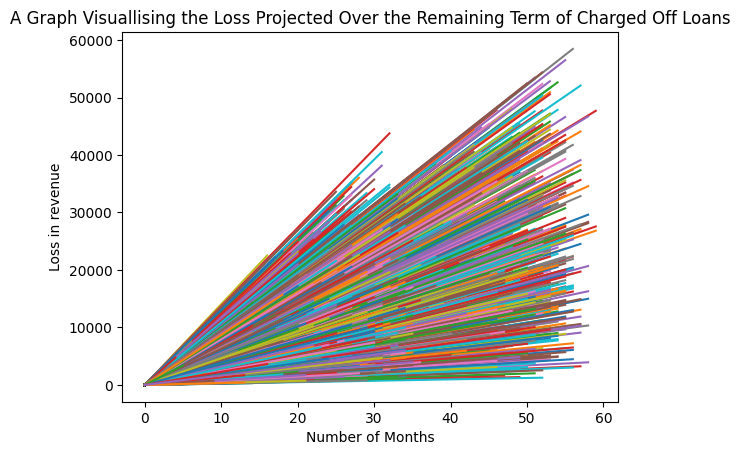

In [46]:
'''
Calculating the percentage of loans that have been a loss (i.e. charged off)
and the total amount that was paid towards these loans before being charged off.

Calculating the loss in revenue these loans would have generated for the company if they had finished 
their term and visualising the loss projected over the remaining term of these loans.
''' 

charged_off_loans = charged_off_total_paid = revenue_lost = 0
term_int_column = new_database['term'].astype('str').map(pd.Series({'36 months': 36, '60 months': 60}))
charged_off_members = []

projected_losses = {}

for index, row in new_database.iterrows(): 
    if 'Charged Off' in row['loan_status'] or row['loan_status'] == 'Default':
 
        charged_off_loans += 1
        charged_off_members.append(row)
        loan_term = term_int_column[index]
        loan_instalment = row['instalment']
        total_paid = row['total_payment']


        charged_off_total_paid += total_paid
        payment_left = (loan_term * loan_instalment) - total_paid
        instalments_left = round(payment_left/loan_instalment)
        revenue_lost += payment_left
        projected_losses[index] = [round(i*loan_instalment,2) for i in range(instalments_left)]

projected_loss_df = pd.DataFrame.from_dict(dict([ (member,pd.Series(loss)) for member, loss in projected_losses.items() ]))
ax = projected_loss_df.plot(title = 'A Graph Visuallising the Loss Projected Over the Remaining Term of Charged Off Loans', 
                            xlabel= 'Number of Months', ylabel = 'Loss in revenue')
ax.get_legend().remove()

charged_off_percentage = (charged_off_loans/df_info.df_shape()[0]) * 100

print(f"Percentage of loans charged off: {round(charged_off_percentage, 2)}%")
print(f"Amount paid to the loand prior to being charged off: £{round(charged_off_total_paid, 2):,}")
print(f"Loss in revenue: £{round(revenue_lost, 2):,}")

In [47]:
'''
Finding the percentage of users who are currently behind with their loan payments and what they currently 
represent as a percentage of all loans. Calculating how much loss the company would incur if their status was 
changed to Charged Off. 

If customers late on payments converted to Charged Off, calculating the percentage of total expected revenue 
these customers and the customers who have already defaulted on their loan represent.
'''

late_members = []
late_payments = remaining_payments = total_payments = 0
late_payment_markers = ['Late (16-30 days)', 'In Grace Period', 'Late (31-120 days)']

for number, individual in new_database.iterrows():

    total_payments += individual['total_payment'] 

    if individual['loan_status'] in late_payment_markers:
        late_payments += 1
        late_members.append(individual)

        remaining_payments += individual['out_prncp'] 

total_loss = remaining_payments + revenue_lost
late_payment_percentage = (late_payments/df_info.df_shape()[0]) * 100
loss_percentage = (total_loss/total_payments) * 100

print(f"Number of late payments: {late_payments}")
print(f"Percentage of loan payments that are late: {round(late_payment_percentage, 2)}%")
print(f"Amount of loss if users with late loan payments were changed to Charged Off: £{round(remaining_payments,2)}")
print(f"Percentage of total expected revenue that late and charged off loans represent: {round(loss_percentage, 2)}%")

Number of late payments: 901
Percentage of loan payments that are late: 1.73%
Amount of loss if users with late loan payments were changed to Charged Off: £995.69
Percentage of total expected revenue that late and charged off loans represent: 10.31%


In [89]:
'''
Analysing the data to visualise the possible indicators that a customer will not be able to pay the loan.
'''

charged_off_df = updated_charged_off_df = pd.DataFrame(charged_off_members).select_dtypes(exclude=['datetime64[ns]'])
late_df = updated_late_df = pd.DataFrame(late_members).select_dtypes(exclude=['datetime64[ns]'])

for col_title in categorical_data:
    for col_index in range(len(categorical_data)):
        crosstab = pd.crosstab([col_title], [categorical_data[col_index]])
        chi_val, p_val, degree, freqs = scipy.stats.chi2_contingency(crosstab)
        
        if p_val < 0.05:
            print(f"Colummns {col_title} and {categorical_data[col_index]} have a relationship.")

updated_charged_off_df = df2_transform.dummy_df(charged_off_df, updated_charged_off_df)
updated_late_df = df2_transform.dummy_df(late_df, updated_late_df)

charged_off_corr_matrix = df_info.check_correlation(updated_charged_off_df)
late_corr_matrix = df_info.check_correlation(updated_late_df)
np.seterr(divide='ignore', invalid='ignore')

filter1 = charged_off_corr_matrix.abs() < 1
filter2 = charged_off_corr_matrix.abs() > 0.6

charged_off_correlations = charged_off_corr_matrix.where(filter1 & filter2 & np.triu(np.ones((508,508)), k=1)).stack().sort_values()


late_correlations = late_corr_matrix.where((late_corr_matrix.abs()<1) & (late_corr_matrix.abs()>0.6) & np.triu(np.ones((223,223)), k=1)).stack().sort_values()
unpaid_common_variables = []
late_variables = []
charged_off_variables = []

for late_term, late_correlation in late_correlations.items():
    late_variables.append(late_term)
    for charged_term, charged_correlation in charged_off_correlations.items():
        charged_off_variables.append(charged_term)
        if set(late_term) == set(charged_term):
            unpaid_common_variables.append(late_term)

late_variables = list(set(late_variables))
charged_off_variables = list(set(charged_off_variables))

print('The following variables have a strong correlation for all unpaid loans:')
for unpaid_var in unpaid_common_variables:
    print(f"{unpaid_var[0]} and {unpaid_var[1]}")

print('\n\nThe following variables have a strong correlation for charged off loans:')
for charged_var in charged_off_variables:
    print(f"{charged_var[0]} and {charged_var[1]}") 

print('\n\nThe following variables have a strong correlation for late loans:')
for late_var in late_variables:
    print(f"{late_var[0]} and {late_var[1]}")

The following variables have a strong correlation for all unpaid loans:
MORTGAGE and RENT
open_accounts and total_accounts
A and A5
6.62 and A2
25.89 and G3
instalment and total_rec_int
7.9 and A4
loan_amount and total_payment
instalment and total_payment
loan_amount and total_rec_int
total_payment and total_rec_int
24.5 and F3
loan_amount and instalment
24.08 and F2


The following variables have a strong correlation for charged off loans:
25.89 and G3
Charged Off and Does not meet the credit policy. Status:Charged Off
open_accounts and total_accounts
24.5 and F3
7.9 and A4
instalment and total_rec_int
instalment and total_payment
loan_amount and total_rec_int
loan_amount and total_payment
out_prncp and Default
A and A5
5.42 and A1
24.08 and F2
MORTGAGE and RENT
6.62 and A2
loan_amount and instalment
36 months and 60 months
total_payment and total_rec_int


The following variables have a strong correlation for late loans:
25.8 and G1
open_accounts and total_accounts
18.55 and D2
24.5 